In [1]:
import torch
from torch.nn import functional as F
from bitsandbytes import functional as bnbf
from auto_gptq.quantization import GPTQ
from transformers import AutoModelForCausalLM
from copy import deepcopy

torch.random.manual_seed(42)
torch.set_default_device("cuda")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/xinyu/anaconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA SETUP: CUDA runtime path found: /home/xinyu/anaconda3/envs/llm/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /home/xinyu/anaconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so...


2023-05-28 00:05:02.343537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 00:05:02.828021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class SimpleQuant:

    def __init__(self, bits=4):
        self.bits = bits

    def find_params(self, x):
        self.maxq = 2**self.bits -1 
        self.scale = (x.max() - x.min()) / self.maxq
        self.zero = round(-x.min().item() / self.scale.item())

    def quantize(self, x):
        r = torch.round(x / self.scale) + self.zero
        return torch.clamp(r, 0, self.maxq)

    def dequantize(self, x):
        return (x - self.zero) * self.scale

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot3compare(title,
                plt_data,
                plt_label,
                x_label,
                y_label,
                x_ticks,
                legend_loc="best",
                sparse=1.0):
    
    x = np.arange(len(plt_data[0])) * sparse

    width = 0.2
    center = len(plt_data) // 2
    for idx, d in enumerate(plt_data):
        plt.bar(x+(idx-center)*width, d, width, label=plt_label[idx])

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x, x_ticks)
    plt.legend(loc=legend_loc)

    plt.show()

In [4]:
def parseint8(x):
    return (x >> 4) & 0b1111, x & 0b1111

## 1*64 Tensor Quant

In [5]:
x = torch.Tensor([0.2, 0.3, 0.7, 1.8]*16)
x = x.to("cuda")

In [6]:
x_i = torch.rand(64, 16).to("cuda")
x_o = x@x_i

### SimpleQuant To Int4

In [7]:
sq = SimpleQuant()
sq.find_params(x)

In [8]:
sq.quantize(x)[:4]

tensor([ 0.,  1.,  5., 15.], device='cuda:0')

In [9]:
sqx = sq.dequantize(sq.quantize(x))
sqx[:4]

tensor([0.2133, 0.3200, 0.7467, 1.8133], device='cuda:0')

In [10]:
sqb = F.mse_loss(x, sqx)
sqb

tensor(0.0007, device='cuda:0')

In [11]:
sqbo = F.mse_loss(x_o, sqx@x_i)
sqbo

tensor(0.5399, device='cuda:0')

In [12]:
def sqi4(x, x_i):
    x_o = x@x_i
    sq = SimpleQuant()
    sq.find_params(x)
    
    print(f"Quant: {sq.quantize(x)[:4]}")

    sqx = sq.dequantize(sq.quantize(x))
    print(f"Dequant: {sqx[:4]}")
    
    sqb = F.mse_loss(x, sqx).item()
    sqbo = F.mse_loss(x_o, sqx@x_i).item()
    print(f"Loss: {sqb}, {sqbo}")
    return sqb, sqbo, sqx

### Quant to FP4

In [13]:
fp4q, fp4qs = bnbf.quantize_fp4(x)
[vv.item() for v in fp4q[:2] for vv in parseint8(v)]

[6, 6, 4, 3]

In [14]:
fp4qx = bnbf.dequantize_fp4(fp4q, fp4qs)
fp4qx[:4]

tensor([0.3000, 0.3000, 0.6000, 1.8000], device='cuda:0')

In [15]:
fp4qb = F.mse_loss(x, fp4qx)
fp4qb

tensor(0.0050, device='cuda:0')

In [16]:
fp4qbo = F.mse_loss(x_o, fp4qx@x_i)
fp4qbo

tensor(0.0348, device='cuda:0')

In [17]:
def qfp4(x, x_i):
    x_o = x@x_i
    fp4q, fp4qs = bnbf.quantize_fp4(x)
    quant_v = [vv.item() for v in fp4q[:2] for vv in parseint8(v)]
    print(f"Quant: {quant_v}")
    
    fp4qx = bnbf.dequantize_fp4(fp4q, fp4qs)
    print(f"Dequant: {fp4qx[:4]}")
    
    fp4qb = F.mse_loss(x, fp4qx).item()
    fp4qbo = F.mse_loss(x_o, fp4qx@x_i).item()
    print(f"Loss: {fp4qb}, {fp4qbo}")
    return fp4qb, fp4qbo, fp4qx

### Quant to NF4

In [18]:
nf4q, nf4qs = bnbf.quantize_nf4(x)
[vv.item() for v in nf4q[:2] for vv in parseint8(v)]

[8, 9, 11, 15]

In [19]:
nf4qx = bnbf.dequantize_fp4(nf4q, nf4qs)
nf4qx[:4]

tensor([0.1432, 0.2897, 0.6082, 1.8000], device='cuda:0')

In [20]:
nf4qb = F.mse_loss(x, nf4qx)
nf4qb

tensor(0.0029, device='cuda:0')

In [21]:
nf4qbo = F.mse_loss(x_o, nf4qx@x_i)
nf4qbo

tensor(1.5706, device='cuda:0')

In [22]:
def qnf4(x, x_i):
    x_o = x@x_i
    nf4q, nf4qs = bnbf.quantize_nf4(x)
    quant_v = [vv.item() for v in nf4q[:2] for vv in parseint8(v)]
    print(f"Quant: {quant_v}")

    nf4qx = bnbf.dequantize_fp4(nf4q, nf4qs)
    print(f"Dequant: {nf4qx[:4]}")

    nf4qb = F.mse_loss(x, nf4qx).item()
    nf4qbo = F.mse_loss(x_o, nf4qx@x_i).item()
    print(f"Loss: {nf4qb}, {nf4qbo}")
    return nf4qb, nf4qbo, nf4qx

### Compare

In [23]:
x_allpos = torch.rand(64).to("cuda")
x_negpos = (torch.rand(64) - torch.rand(64).mean()).to("cuda")
x_nomal = torch.normal(torch.rand(64)).to("cuda")

x_list = [x_allpos, x_negpos, x_nomal]
q_func = [sqi4, qfp4, qnf4]

In [24]:
%%capture
plt_data_tu = [[f(x, x_i) for x in x_list] for f in q_func]

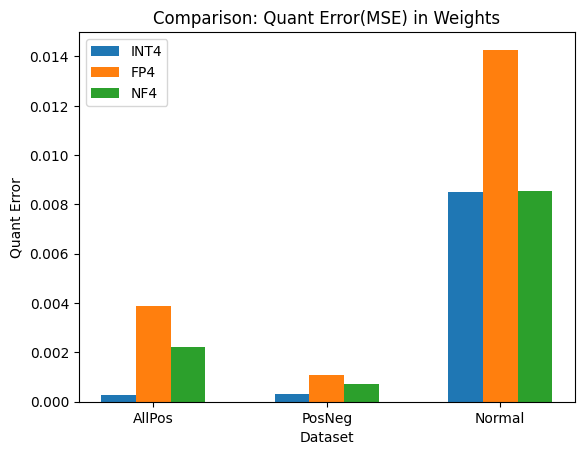

In [25]:
# Not important
plt_data = [[t[0] for t in tt] for tt in plt_data_tu]
plot3compare(
    title='Comparison: Quant Error(MSE) in Weights',
    plt_data=plt_data,
    plt_label=['INT4', 'FP4', 'NF4'],
    x_label='Dataset',
    y_label='Quant Error',
    x_ticks=['AllPos', 'PosNeg', 'Normal'],
    legend_loc="upper left"
)

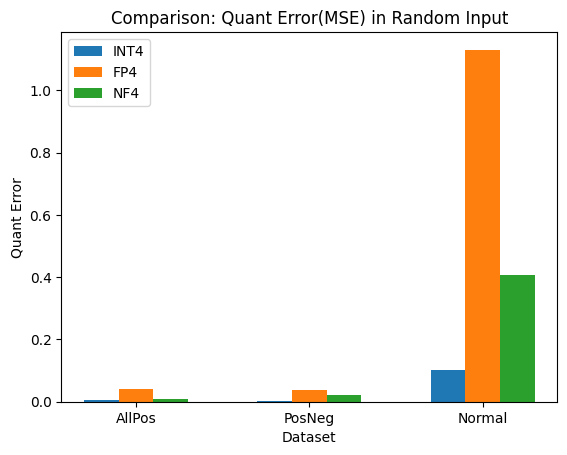

In [26]:
# Important
plt_data = [[t[1] for t in tt] for tt in plt_data_tu]
plot3compare(
    title='Comparison: Quant Error(MSE) in Random Input',
    plt_data=plt_data,
    plt_label=['INT4', 'FP4', 'NF4'],
    x_label='Dataset',
    y_label='Quant Error',
    x_ticks=['AllPos', 'PosNeg', 'Normal'],
    legend_loc="upper left"
)

## Quant OPT-125m

In [27]:
def get_layer_by_name(model, layer_name):
    for name, module in model.named_modules():
        if name == layer_name:
            return module
    raise Exception(f"no layer named {layer_name}")

### Get Layer to Quant

In [28]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")

layer = get_layer_by_name(model, "model.decoder.layers.0.fc2")
layer = layer.to("cuda")
weight_c = layer.weight.clone()

In [29]:
x_i = torch.rand(layer.in_features, 100).to("cuda")

### Quant With simple int4, fp4, nf4

In [30]:
sqi4_loss = sqi4(weight_c, x_i)

Quant: tensor([[8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Dequant: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Loss: 0.0005981011781841516, 0.873798668384552


In [31]:
qfp4_loss = qfp4(weight_c, x_i)

Quant: [4, 9, 9, 4]
Dequant: tensor([[ 0.0271, -0.0004, -0.0004,  ...,  0.0003,  0.0266, -0.0266],
        [-0.0191, -0.0143,  0.0287,  ...,  0.0004, -0.0391, -0.0004],
        [ 0.0172, -0.0086,  0.0343,  ..., -0.0101, -0.0101, -0.0003],
        [ 0.0156,  0.0156,  0.0156,  ...,  0.0122, -0.0183, -0.0122]],
       device='cuda:0')
Loss: 1.2598326975421514e-05, 0.017209840938448906


In [32]:
qnf4_loss = qnf4(weight_c, x_i)

Quant: [12, 7, 7, 11]
Dequant: tensor([[ 0.0358,  0.0000,  0.0000,  ...,  0.0000,  0.0300, -0.0280],
        [-0.0226, -0.0106,  0.0322,  ...,  0.0000, -0.0309, -0.0071],
        [ 0.0174, -0.0095,  0.0289,  ..., -0.0112, -0.0055, -0.0055],
        [ 0.0074,  0.0074,  0.0151,  ...,  0.0118, -0.0209, -0.0067]],
       device='cuda:0')
Loss: 6.642355856456561e-06, 0.007513480260968208


### Quant With GPTQ

In [33]:
gptq = GPTQ(deepcopy(layer))

In [34]:
with torch.no_grad():
    inp = torch.rand(10000, layer.in_features).to("cuda")
    out = layer(inp)
gptq.add_batch(inp, out)

In [35]:
gptq.quantizer.configure(4, perchannel=True)

In [36]:
_ = gptq.fasterquant()

In [37]:
gptq_loss = F.mse_loss(weight_c, gptq.layer.weight.data)
gptq_loss

tensor(3.9267e-05, device='cuda:0', grad_fn=<MseLossBackward0>)

In [38]:
gptq_losso = F.mse_loss(weight_c@x_i, gptq.layer.weight.data@x_i)
gptq_losso

tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

In [39]:
def qgptq(layer, x_i, num_sample=100, use_inp=False):
    weight_copy = layer.weight.clone()
    gptq = GPTQ(deepcopy(layer))
    with torch.no_grad():
        inp = torch.rand(num_sample, layer.in_features).to("cuda")
        if use_inp:
            inp = torch.cat((inp, x_i), 0)
        out = layer(inp)

    gptq.add_batch(inp, out)
    gptq.quantizer.configure(4, perchannel=True)
    _ = gptq.fasterquant()
    w_err = F.mse_loss(weight_copy, gptq.layer.weight.data).item()
    o_err = F.mse_loss((weight_copy@x_i.T).flatten(), (gptq.layer.weight.data@x_i.T).flatten()).item()
    return w_err, o_err, gptq.layer.weight.data

### Compare
Considering that the performance of simple quant is relatively poor, and GPTQ itself is an upgraded version of simple quant, sq no longer participates in the comparison

In [40]:
layer_names = [
    "model.decoder.layers.6.self_attn.q_proj",
    "model.decoder.layers.6.self_attn.k_proj",
    "model.decoder.layers.6.self_attn.v_proj",
    "model.decoder.layers.6.self_attn.out_proj",
    "model.decoder.layers.6.fc1",
    "model.decoder.layers.6.fc2",
]

layers = [get_layer_by_name(model, n).to("cuda") for n in layer_names]
layers_xi = [torch.rand(l.in_features, 100).to("cuda") for l in layers]

In [41]:
%%capture
fp4error_tu = [qfp4(l.weight, layers_xi[idx]) for idx, l in enumerate(layers)]
nf4error_tu = [qnf4(l.weight, layers_xi[idx]) for idx, l in enumerate(layers)]
gptqerror_tu = [qgptq(l, layers_xi[idx].T, 100) for idx, l in enumerate(layers)]
gptqerror_data100_tu = [qgptq(l, layers_xi[idx].T, 100, True) for idx, l in enumerate(layers)]
gptqerror_data100000_tu = [qgptq(l, layers_xi[idx].T, 100000, True) for idx, l in enumerate(layers)]

In [42]:
layer_errors = [fp4error_tu, nf4error_tu,gptqerror_data100_tu,  gptqerror_data100000_tu, gptqerror_tu]

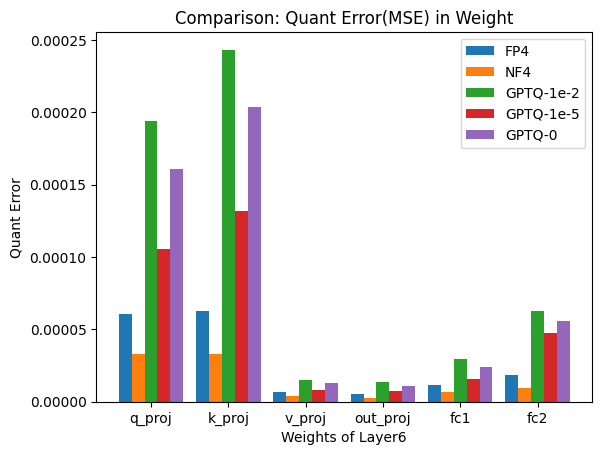

In [43]:
plt_data = [
    [t[0] for t in d]
    for d in layer_errors
]
plot3compare(
    title='Comparison: Quant Error(MSE) in Weight',
    plt_data=plt_data,
    plt_label=['FP4', 'NF4', 'GPTQ-1e-2', "GPTQ-1e-5", "GPTQ-0"],
    x_label='Weights of Layer6',
    y_label='Quant Error',
    x_ticks=['q_proj', 'k_proj', 'v_proj', 'out_proj', 'fc1', "fc2"],
    legend_loc="upper right",
    sparse=1.2
)

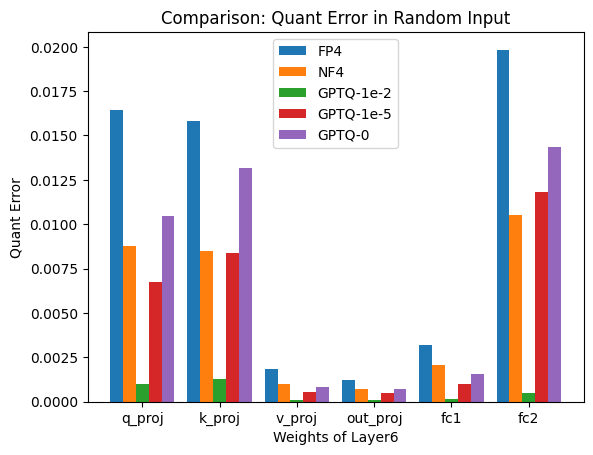

In [44]:
plt_data = [
    [t[1] for t in d]
    for d in layer_errors
]
plot3compare(
    title='Comparison: Quant Error in Random Input',
    plt_data=plt_data,
    plt_label=['FP4', 'NF4', 'GPTQ-1e-2', "GPTQ-1e-5", "GPTQ-0"],
    x_label='Weights of Layer6',
    y_label='Quant Error',
    x_ticks=['q_proj', 'k_proj', 'v_proj', 'out_proj', 'fc1', "fc2"],
    legend_loc="upper center",
    sparse=1.2
)

## TransformerBlockWise Quant 

In [45]:
quant_names = ["self_attn.k_proj", "self_attn.v_proj", "self_attn.q_proj", "self_attn.out_proj", "fc1", "fc2"]

def quant_layer(layer, x, num_sample=100):
    ground_t = layer(x)[0]
    fp4_layer = deepcopy(layer)
    nf4_layer = deepcopy(layer)
    gptq_layer = deepcopy(layer)
    
    for name, mod in fp4_layer.named_modules():
        if name in quant_names:
            _, _, mod.weight.data = qfp4(mod.weight, torch.zeros(mod.in_features))
    
    for name, mod in nf4_layer.named_modules():
        if name in quant_names:
            _, _, mod.weight.data = qnf4(mod.weight, torch.zeros(mod.in_features))
    
    for name, mod in gptq_layer.named_modules():
        if name in quant_names:
            _, _, mod.weight.data = qgptq(mod, torch.zeros(mod.in_features), num_sample)

    fp4e = F.mse_loss(ground_t, fp4_layer(x)[0]).item()
    nf4e = F.mse_loss(ground_t, nf4_layer(x)[0]).item()
    gptqe = F.mse_loss(ground_t, gptq_layer(x)[0]).item()

    return fp4e, nf4e, gptqe

In [46]:
quant_layers_names = [
    "model.decoder.layers.0",
    "model.decoder.layers.2",
    "model.decoder.layers.6",
    "model.decoder.layers.9",
    "model.decoder.layers.10",
    "model.decoder.layers.11"
]

quant_layers = [get_layer_by_name(model, n) for n in quant_layers_names]

In [47]:
x_i = torch.rand(1, 100, 768)

In [48]:
%%capture
plt_data = [quant_layer(l, x_i) for l in quant_layers]

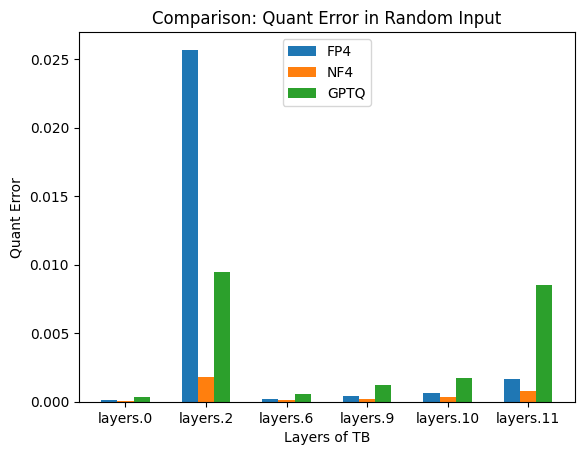

In [49]:
plt_data = [list(d) for d in plt_data]
plt_data = np.mat(plt_data).T.tolist()

x_ticks = [ln[ln.rindex("layers", ):] for ln in quant_layers_names]
plot3compare(
    title='Comparison: Quant Error in Random Input',
    plt_data=plt_data,
    plt_label=['FP4', 'NF4', 'GPTQ'],
    x_label='Layers of TB',
    y_label='Quant Error',
    x_ticks=x_ticks,
    legend_loc="upper center"
)